# **Fake And Real News Classification**

---

Authors: [Femi Kamau](https://www.github.com/ctrl-Karugu), [Monicah Iwagit](), [Teofilo Gafna](), [Wendy Mwiti](https://www.github.com/WendyMwiti)

## 1. Business Understanding

## 2. Data Understanding

Load Libraries

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
import re
from nltk.corpus import stopwords
from nltk.collocations import *
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import pickle
import spacy
import unidecode
from word2number import w2n
import contractions
import re


nlp = spacy.load('en_core_web_sm')

# Remove 'no' and 'not' from SpaCy's stop words list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False
    
pd.set_option('display.max_colwidth', None)

Load Data

In [3]:
# Load the real news data
real = pd.read_csv('./data/True.csv')

# Load the fake news data
fake = pd.read_csv('./data/Fake.csv')

In [88]:
# Preview real data
real.head(2)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   
1  U.S. military to accept transgender recruits on Monday: Pentagon   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [87]:
# Preview the fake data
fake.head(2)

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was know

In [6]:
#  Add a column called 'category' to both DataFrames which will become our taget variable
real['category'] = 1
fake['category'] = 0

In [7]:
# Combine both DataFrames 
data = pd.concat([real, fake])

In [89]:
# Preview the new DataFrame head
data.head(2)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle return holiday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadow among republican voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryan early remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary non defense program social spending tackling issue dreamer people brought illegally country child trump put expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader white house said trump also scheduled meet florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December
1,U.S. military to accept transgender recruits on Monday: Pentagon,washington reuters transgender people allowed first time enlist military starting ordered federal court pentagon said president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requiring military begin accepting transgender recruit justice department official said administration challenge ruling department defense announced releasing independent study issue coming week rather litigate interim appeal occurs administration decided wait dod study continue defend president

In [90]:
# Preview the new DataFrame tail
data.tail(2)

,title,text,subject,date,category,year,month
23479,How to Blow $700 Million: Al Jazeera America Finally Calls it Quits,century wire say jazeera america history one biggest failure broadcast medium history ever since ally began plotting overthrow jazeera deteriorated promising international news network become full blown agit prop medium shop state department pentagon fact military central command centcom middle east region located capital doha conveniently located road jazeera headquarters nice cozy jazeera role promoting regime change destablization recorded history many shameful exhibition medium fakery qatari royal tried expand propaganda operation north america matter much money threw royal love throwing money thing try get work one cared much le watched know massive disappointment everyone worked tirelessly long term future decision made way ajam done anything great job read company email ceo anstey obtained politico indeed tried everything seems short paying american watch program jazeera america close jazeera america qatari owned jazeera purchased current gore inflated million wait get worse money nothing gore got fat ajam deal addition million doha blew buying gore lemon current qatari spent least million per year along many million spent advertising ajam network slot online ad along billboard print medium promotion qatari easy ticket cable satellite network boy gore pull fast one total would looking million whole party apex ajam would lucky pull viewer prime time really amount nothing market share money considering hundred staff medium executive producer employed safe say someone clue colossal joke bright side qatari always blame collapse oil price lack spare cash fund propaganda mill read mainstream medium epic fails century wire msm watch,middle_east,2016-01-14,0,2016.0,January
23480,10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt,century wire say wire predicted new year look ahead new hostage crisis underway today iranian military force report two small riverine navy boat seized iranian water currently held farsi island persian gulf total navy personnel nine men one woman detained iranian authority navy strayed navy patrol boat persian gulf image source usni according pentagon initial narrative follows sailor training mission around noon boat experienced mechanical difficulty drifted iranian claimed water detained iranian coast guard official added story since slightly revised white house spokesman josh earnest follow narrative boat traveling route stopped detained iranian according usni search rescue team harry truman strike group scrambled aid crew stopped short crew taken iranian contact received assurance crew vessel returned promptly pentagon spokesman peter cook told according persian gulf farsi island one iranian island persian gulf bushehr province irgc navy base island island area completely restricted public due top secret governmental activity according nbc news state department touch tehran official iranian recognize navy straying course mistake sailor released within hour war inc cnn wolf blitzer wasted time ramping talk military tension israeli financed neocon senator tom cotton neocon stuntalready medium including cnn fox running talking point could come worse time president obama right tonight state union speech trying prove people country trusted implement historic nuclear deal latest naval controversy also come day implementation phase nuclear deal say coincidence might naive said could gop aligned member pentagon intelligence establishment helped engineer today bizarre mini crisis order help weaken relation extension obama controversial iranian nuclear deal look likely case evidenced quick appearance lobby sponsored pro war senator tom cotton placed cnn direct aggressive military talking point live air story broke today cotton photo left immediately called event hostile blamed boat drifting iranian water blamed crisis president obama claim emboldened iranian aggr

In [9]:
class dataUnderstanding(object):
    """A class that does basic Data Understanding"""
    
    def __init__(self, df):
        self.shape = df.shape
        self.info = df.info
        self.duplicates = df.duplicated().sum()
        self.missing = df.isna().sum()
        self.types = df.dtypes

In [10]:
# Instantiate the class
understanding = dataUnderstanding(data)

In [11]:
# Summary of the dataset
print(f"Shape:{understanding.shape}")
print()
print(understanding.info())

Shape:(44898, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None


From the summary above, we can see that the dataset contain 44898 rows and spans 5 columns. The columns are: title, text, subject, date and category. The category column is the target variable and the rest are the features.

Furthermore, the dataset contains 4 object columns and 1 integer column. The object columns are: title, text, subject and date. The integer column is: category (target variable). We may need to convert the date column to datetime format in the data preparation phase.

The dataset does not contain any missing values.

In [12]:
# Check for duplicates
print(f"Duplicates: {understanding.duplicates}")

Duplicates: 209


The dataset contains 209 duplicates. They shall be inspected and removed if necessary in the data preparation phase.

In [13]:
# Check the number of missing values
understanding.missing

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [14]:
# Inspect the value counts in the subject column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The articles that are within this dataset fall under 8 different subjects. These are: politicsNews, worldnews, News, politics, left-news, Government News, US_News, and Middle-east.

In [15]:
# Inspect the value counts in the category column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The dataset is fairly balanced between fake and real news 

In [16]:
# Inspect the date column
data['date'].nunique()

2397

The date column contains 2397 unique dates

## 3. Data Preparation


### 3.1 Validity

> To ensure validity within the dataset, we will be checking that the data is in the correct format.

In [17]:
# Converting the subject column to category
data['subject'] = data['subject'].astype('category')

In [91]:
# Converting date from object to datetime
data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

# Type of the date column
data['date'].dtype

# Preview the updated DataFrame 
data.head(1)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle return holiday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadow among republican voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryan early remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary non defense program social spending tackling issue dreamer people brought illegally country child trump put expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader white house said trump also scheduled meet florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December


In [19]:
# Extract the months and the years from the date column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime('%B')

In [20]:
# Inspect the updated datatypes
data.dtypes

title               object
text                object
subject           category
date        datetime64[ns]
category             int64
year               float64
month               object
dtype: object

### 3.2 Consistency

> In this section, we will be obeserving the consistency of the data. We will be checking for duplicates

In [92]:
# Create a dataframe for the duplicated to be inspected
duplicates  = data[data.duplicated()]
duplicates.head(3)

title  \
10924  MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead   
18654  MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [22]:
# Drop the duplicates
print(f"Before dropping: {len(data)}")
data.drop_duplicates(inplace=True)
print(f"After dropping: {len(data)}")

Before dropping: 44898
After dropping: 44689


Remove the URLS from the text column

### 3.3 Completeness

From data understanding section we found there to be no missing values. Therefore we can confirm that the the dataset is complete.

### 3.4 Uniformity

 To check on whether different systems refer to the same value in the same format

In [23]:
# Check the value counts of the subject column
data['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [24]:
# Rename the categories in the subject column
data['subject'].replace({'politicsNews': 'politics',
                         'worldnews': 'world_news',
                         'News': 'news',
                         'left-news': 'left_news',
                         'Government News': 'government_news',
                         'US_News': 'us_news',
                         'Middle-east': 'middle_east'}, inplace=True)


In [25]:
# Preview the updated subject column value counts
data['subject'].value_counts()

politics           18058
world_news          9991
news                9050
left_news           4459
government_news     1570
us_news              783
middle_east          778
Name: subject, dtype: int64

### 3.5 Exploratory Data Analysis

#### 3.5.1 Univariate Analysis

In [26]:
# Create a function that visualizes the value counts of a column
def plot_bar(df, col)-> None:
    """ A function that returns a plot count of columns"""
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x = col, order=df[col].value_counts().index)
    plt.title(f"{col} count plot")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()
    

##### 3.5.1.1 `text`

In [27]:
def plot_word_cloud(df, target, feature, i:int):
    """This fuction creates a wordcloud for the news texts"""
    real_news =df[df[target]==i]
    text = data[feature].values
    wordcloud = WordCloud(
        max_words = 400,
        width = 800,
        height = 600,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (14, 8),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

##### Fake News Visualization Word Cloud

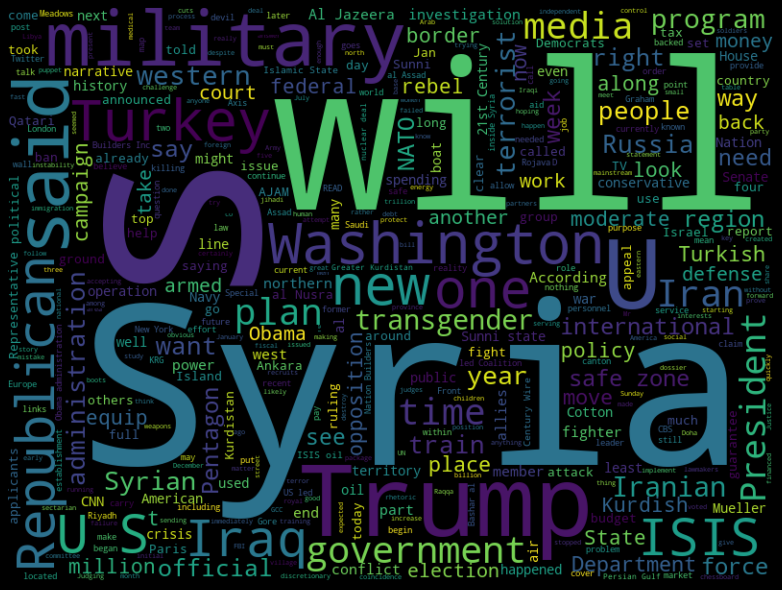

In [28]:
plot_word_cloud(data, 'category', 'text', 0)

##### Real News Visualization Word Cloud

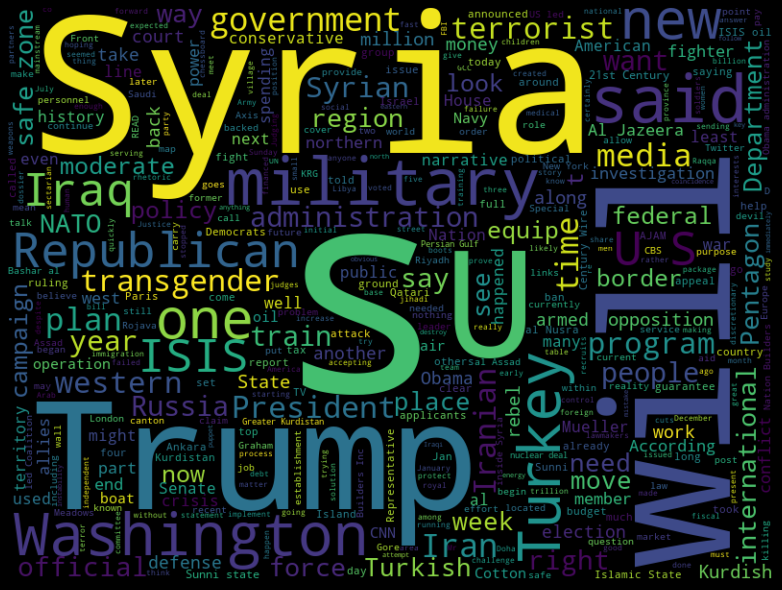

In [29]:
plot_word_cloud(data, 'category', 'text', 1)

##### 3.5.1.2 `subject`

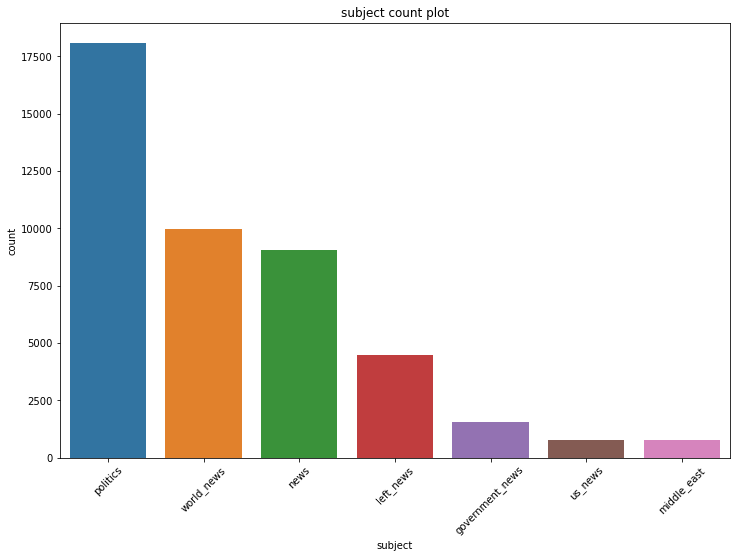

In [30]:
# Plotting a countplot of the subject
plot_bar(data, 'subject')

Observations:
* Most of the published news talk about politics followed by world news while the least discussed subject is the Middle East

##### 3.5.1.3 `month`

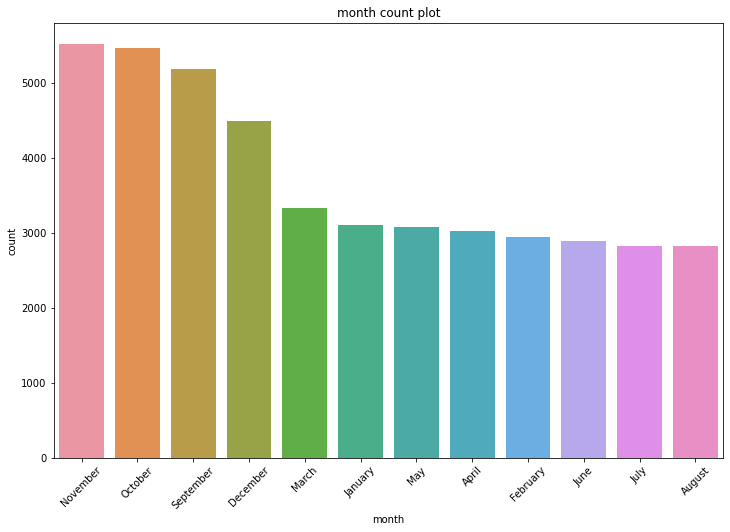

In [31]:
# Plotting a countplot of the Months
plot_bar(data, 'month')

Observations:
* Most of the news is published during the month of November followed by October and September.
* It is also worth noting that the months of September and October precede November.
* The month of August registered the least number of published news

##### 3.5.1.4 `year`

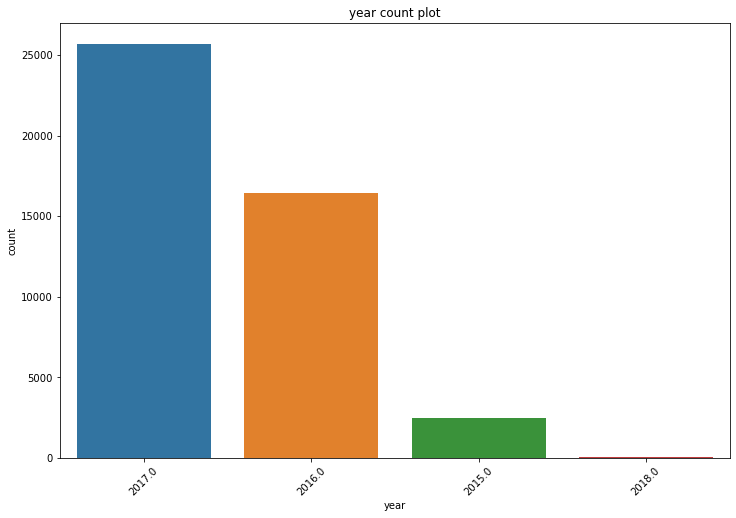

In [32]:
# Plotting the years
plot_bar(data, 'year')

Observations:
* 2017 had the most news followed by 2016

##### 3.5.1.5 `category`

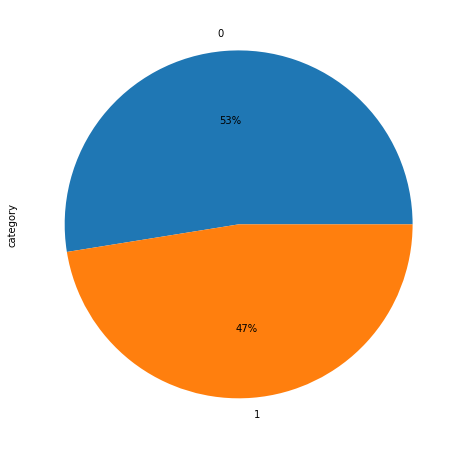

In [33]:
# Plotting a pie chart for the column 'category'
fig, ax = plt.subplots(figsize=(12,8))
data['category'].value_counts().plot(kind='pie', autopct='%.0f%%');

Observations:
* The data set is fairly balanced. However, fake news is slightly more than real news.

#### 3.5.2 Bivariate Analysis

In [34]:
# Creating a function that plots a count plot with respect to another column
def plot_bivariate(df, col, by):
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=col, hue=by)
    plt.title(f"{col} count plot by {by}")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()

##### 3.5.2.1 `month` & `category`

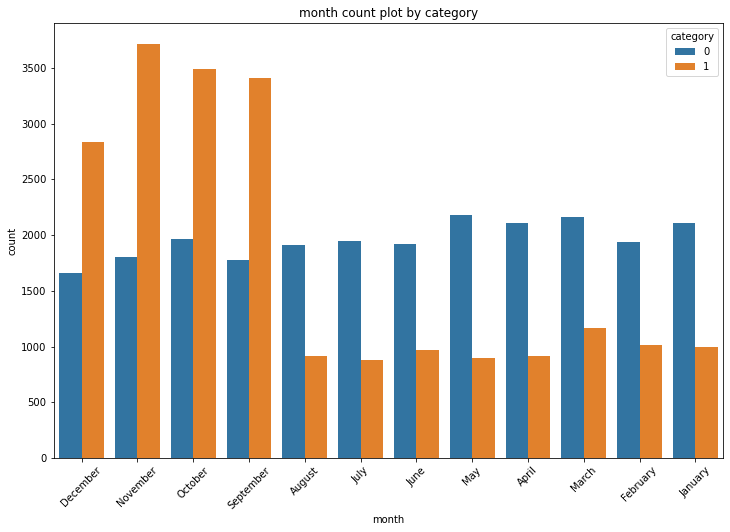

In [35]:
# Plotting month by category
plot_bivariate(data, 'month', 'category')

Observations:
* 

##### 3.5.2.2 `year` & `category`

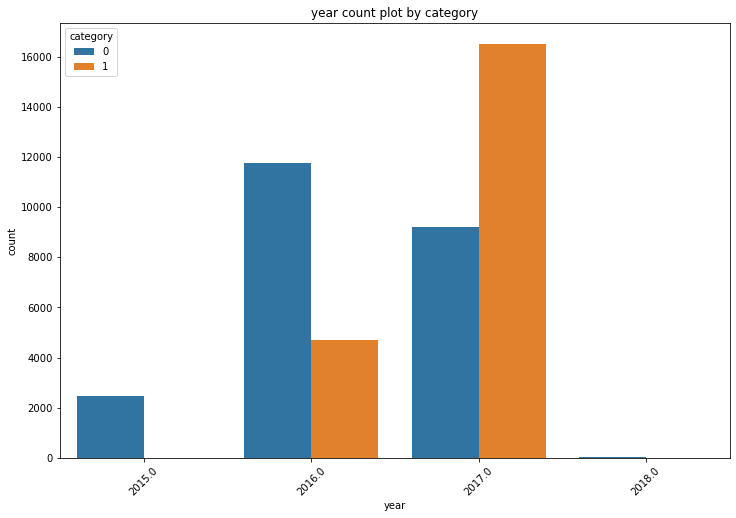

In [36]:
# plot year by category
plot_bivariate(data, 'year', 'category')

Observations:
* 

##### 3.5.2.3 `subject` & `category`

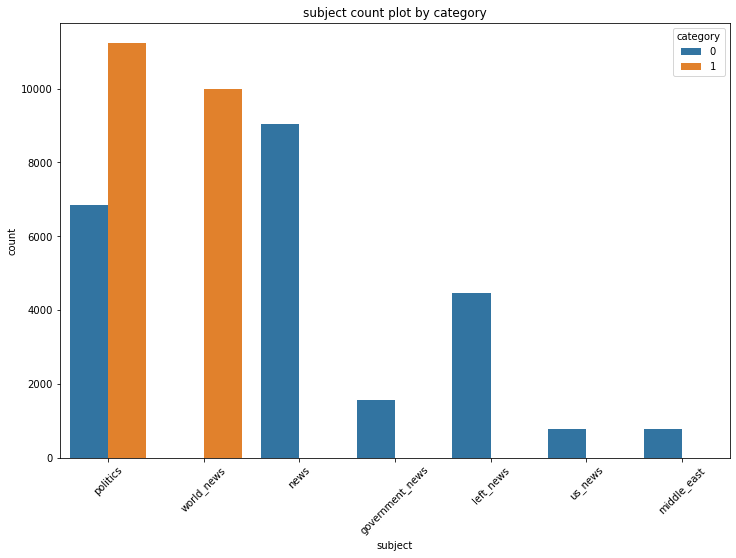

In [37]:
plot_bivariate(data, 'subject', 'category')

## 4. Modeling

### 4.1 Data Preprocessing

In [40]:
# A function to remove web tags
def remove_web_tags(text):
    """Remove html tags from a string"""
    # Remove https links
    clean = re.compile(r'https\S*')
    text = re.sub(clean, '', text)

    # Remove data '.com' links
    clean = re.compile(r'\S+\.com\S+')
    return re.sub(clean, '', text)


# Function to remove twitter handles
def remove_twitter_handles(text):
    """This function removes twitter handles from a string"""
    clean = re.compile(r'@\S*')
    return re.sub(clean, '', text)


# Function to convert Non-ASCII characters to ASCII
def remove_accented_chars(text):
    """This function removes accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


# Function to expand contractions
def expand_contractions(text):
    """Expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


# Function to remove special characters
def remove_special_characters(text):
    """This function removes special characters from text, e.g. $"""
    clean = re.compile(r'[^a-zA-Z0-9\s]')
    return re.sub(clean, ' ', text)


# Function to lowercase text
def lowercase_text(text):
    """This function converts characters to lowercase"""
    return text.lower()


# Function to convert number words to digits
def convert_number_words(text):
    """Convert number words to digits and remove them"""
    
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)

    for i, token in enumerate(tokens):
        try:
            tokens[i] = str(w2n.word_to_num(token))
        except:
            pass
    
    return ''.join(tokens)


# Function to remove numbers
def remove_numbers(text):
    """This function removes numbers from text"""
    clean = re.compile(r'\d+')
    return re.sub(clean, '', text)


# Function to remove short words
def remove_small_words(text):
    """This function removes words with length 1 or 2"""
    clean = re.compile(r'\b\w{1,2}\b')
    return re.sub(clean, '', text)


# Function to remove names of people
def remove_names(text):
    """This is a function that removes the names from text"""
    with open('./data_preprocessing/names.txt', 'r') as f:
        NAMES = set(f.read().splitlines())

        NAMES = [name.lower() for name in NAMES]
        
    pattern = r'\W+'
    tokens = re.split(pattern, text)
    
    words = tokens
      
    for token in tokens:
        if token in NAMES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove countries
def remove_countries(text):
    """This is a function that removes the countries from text"""
    with open('./data_preprocessing/countries.txt', 'r') as f:
        COUNTRIES = set(f.read().splitlines())

        COUNTRIES = [name.lower() for name in COUNTRIES]
        
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)
    
    words = tokens
    
    for token in tokens:
        if token in COUNTRIES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove US cities of people
def remove_cities(text):
    """This is a function that removes the US cities from text"""
    with open('./data_preprocessing/cities.txt', 'r') as f:
        CITIES = set(f.read().splitlines())

        CITIES = [name.lower() for name in CITIES]
        
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)
    
    words = tokens
    
    for token in tokens:
        if token in CITIES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove days and months
def remove_days_and_months(text):
    """This is a function that removes the months and years from text"""
    
    # Load the months
    with open('./data_preprocessing/months.txt', 'r') as f:
        MONTHS = set(f.read().splitlines())

        MONTHS = [name.lower() for name in MONTHS]
    
    # Load the days of the week
    with open('./data_preprocessing/week.txt', 'r') as f:
        WEEK = set(f.read().splitlines())

        WEEK = [name.lower() for name in WEEK]
      
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)  
    
    words = tokens
    
    for token in tokens:
        if token in MONTHS:
            while token in words:
                words.remove(token)
     
    for token in tokens:
        if token in WEEK:
            while token in words:
                words.remove(token)
            
    text = ' '.join(words)
            
    return text


def stopwords(text):
    """This function removes the stopwords in the text"""
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    
    tokens = re.split(r'(\W+)', text)
    
    text = [token for token in tokens if token not in stopwords]

    return ' '.join(text)


# Function to remove extra spaces
def remove_whitespace(text):
    """Remove extra spaces from a string"""
    
    clean = re.compile(r'\s{2,10000}')
    text = re.sub(clean, ' ', text)
    
    return text


# Lemmatize text
def lemmatize(text):
    lemma = WordNetLemmatizer()
    
    tokens = re.split('\W+', text)
    
    text = [lemma.lemmatize(token) for token in tokens]
    
    return ' '.join(text)
  

In [41]:
# Remove the web tags in the text
data['text'] = data['text'].apply(remove_web_tags)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [42]:
# Remove the twitter handles from the text
data['text'] = data['text'].apply(remove_twitter_handles)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [43]:
# Remove the accented characters
data['text'] = data['text'].apply(remove_accented_chars)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [44]:
# Expand the contractions
data['text'] = data['text'].apply(expand_contractions)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [45]:
# Remove the special characters
data['text'] = data['text'].apply(remove_special_characters)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [46]:
# Lowercase the text
data['text'] = data['text'].apply(lambda x: x.lower())

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [47]:
# Convert numeric words to numbers
data['text'] = data['text'].apply(remove_numbers)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [48]:
# Remove short words (less than 3 characters)
data['text'] = data['text'].apply(remove_small_words)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [49]:
# Remove names of countries
data['text'] = data['text'].apply(remove_countries)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [50]:
# Remove the days and months
data['text'] = data['text'].apply(remove_days_and_months)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [51]:
# Remove the stopwords
data['text'] = data['text'].apply(stopwords)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [52]:
# Remove the whitespace
data['text'] = data['text'].apply(remove_whitespace)

data.head(1)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cuts called fiscal conservative urged budget restraint keeping sharp pivot way among republicans representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle return holidays lawmakers begin trying pass federal budget fight likely linked issues immigration policy even congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases non defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadows among republicans voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion years trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united states borrow trillion paid future generations finance tax cuts corporations rich one least fiscally responsible bills ever seen passed history house representatives think going paying many many years come crowley said republicans insist tax package biggest tax overhaul years boost economy job growth house speaker paul ryan also supported tax bill recently went meadows making clear radio interview welfare entitlement reform party often calls would top republican priority republican parlance entitlement programs mean food stamps housing assistance medicare medicaid health insurance elderly poor disabled well programs created washington assist needy democrats seized ryan early remarks saying showed republicans would try pay tax overhaul seeking spending cuts social programs goals house republicans take back seat senate votes democrats needed approve budget prevent government shutdown democrats use leverage senate republicans narrowly control defend discretionary non defense programs social spending tackling issue dreamers people brought illegally country children trump put expiration date deferred action childhood arrivals daca program protects young immigrants deportation provides work permits president said recent twitter messages wants funding proposed mexican border wall immigration law changes exchange agreeing help dreamers representative debbie dingell told cbs favor linking issue policy objectives wall funding need daca clean said trump aides meet congressional leaders discuss issues followed weekend strategy sessions trump republican leaders white house said trump also scheduled meet florida republican governor rick scott wants emergency aid house passed billion aid package hurricanes florida texas puerto rico wildfires california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December


In [53]:
# Lemmatize the data
data['text'] = data['text'].apply(lemmatize)

data.head(1)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle return holiday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadow among republican voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryan early remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary non defense program social spending tackling issue dreamer people brought illegally country child trump put expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader white house said trump also scheduled meet florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December


Fake News Word Cloud (After Preprocessing)

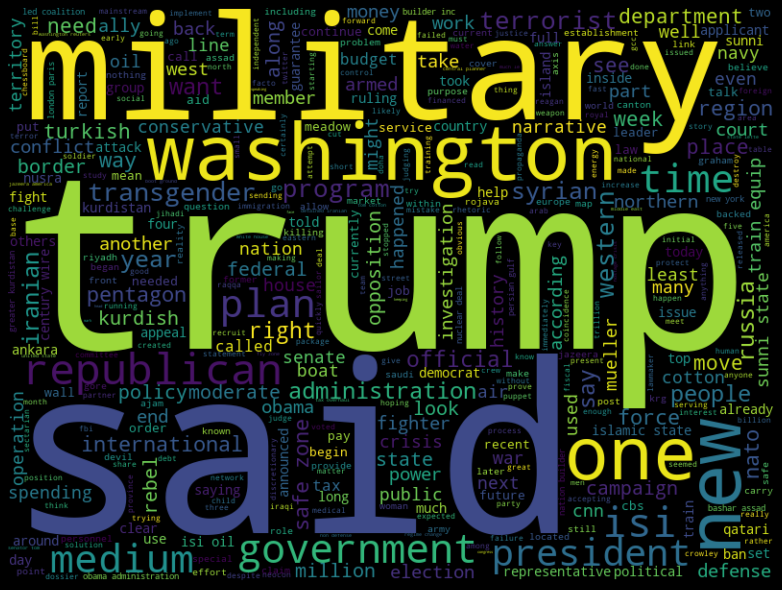

In [84]:
# WordCloud after preprocessing
plot_word_cloud(data, 'category', 'text', 0)

Real News Word Cloud (After Preprocessing)

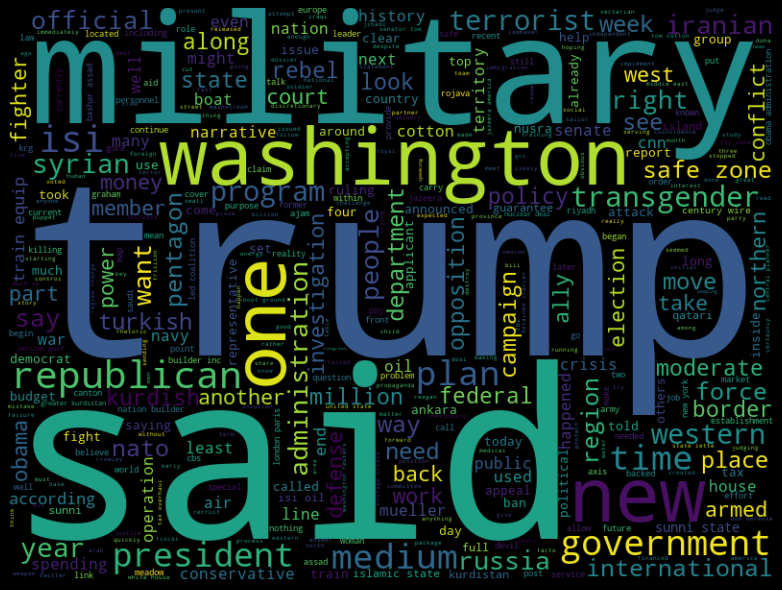

In [85]:
# WordCloud after preprocessing
plot_word_cloud(data, 'category', 'text', 1)

### 4.2 Train Models

#### 4.2.1 Splitting the dataset

In [54]:
X = data['text']
y = data['category']

# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 4.2.2 Vectorization

In [55]:
# Declaring a Vectoriser
tfidf_vect = TfidfVectorizer()

# 'Fitting' the Vectoriser
tfidf_vect_fit = tfidf_vect.fit(X_train)

# Creating 'Test' and 'Train' vectorised dataframes
tfidf_train = tfidf_vect_fit.transform(X_train)
tfidf_test = tfidf_vect_fit.transform(X_test)

# Checking, if we did everything alright
tfidf_train

<31282x79106 sparse matrix of type '<class 'numpy.float64'>'
	with 4727149 stored elements in Compressed Sparse Row format>

In [ ]:
# Define function to get evaluation scores and plot a confusion matrix
def score_model(model, y_test_true, X_test):
    """ A function that returns scores of a model as well as a confusion matrix"""
    
    y_pred = model.predict(X_test)
    
    precision, recall, fscore, train_support = score(y_test_true, y_pred, pos_label=1, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(accuracy_score(y_test_true,y_pred), 3)))
    
    # Create a confusion matrix 
    cm = confusion_matrix(y_test_true, y_pred)

    # Make a Dataframe, of the metrics with classes
    class_label = [0, 1]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)

    # Plot the Model
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 4.2.3 Simple Models

##### 4.2.3.1 Logistic Regression

Precision: 0.982 / Recall: 0.983 / F1-Score: 0.982 / Accuracy: 0.983


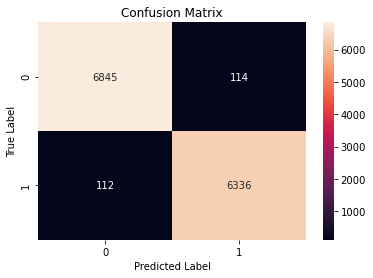

In [57]:
# Instantiate the Logistic Regression Algorithm  
lr = LogisticRegression()

# Fit Algorithm
lr.fit(tfidf_train, y_train)

score_model(lr, y_test, tfidf_test)

The accuracy of the logistic regression model implies that 98.3% of the time, the model correctly classifies a news article as true or fake.

The precision and recall scores are 98.2 % and 98.3% respectively. Implying that out of the total real news, 98.2 % were truly real.

112 samples were classified as fake yet they were true. On the other hand, 114 samples were classified as true yet they were false.

13181 samples were correctly classified correctly.

##### 4.2.3.2 Random Forest Algorithm

Precision: 0.98 / Recall: 0.982 / F1-Score: 0.981 / Accuracy: 0.982


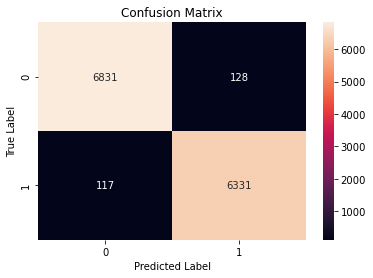

In [58]:
# Instantiate the Naive Bayes Algorithm# 
rf = RandomForestClassifier(min_samples_leaf=20, min_samples_split=20, random_state=100)

# Fit Algorithm
rf = rf.fit(tfidf_train , y_train)

score_model(rf, y_test, tfidf_test)

The random forest model performs slightly worse than the logistic regression model with an accuracy score of 98.2%. 

This implies that 98.2% of the time, a news article is correctly classified as real or fake. 

The precision and recall scores are 98% and 98.2% respectively. Implying that out of the total real news, 98.1% were truly real. 117 samples were classified as fake yet they were true. 

On the other hand, 128 samples were classified as true yet they were false. 13177 samples were correctly classified correctly.

### 4.3 Advanced ML Models

#### 4.3.1 Ada Boosting Classifier

Precision: 0.994 / Recall: 0.996 / F1-Score: 0.995 / Accuracy: 0.995


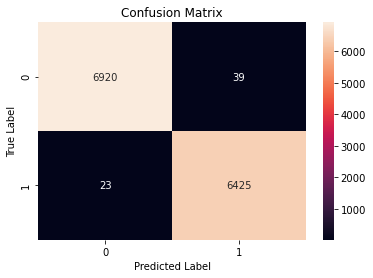

In [59]:
# Instantiating an AdaBoost Classifier
ada_boost = AdaBoostClassifier()

# Fitting the model on the training data
ada_boost.fit(tfidf_train, y_train)

# scoring the adaboost model
score_model(ada_boost, y_test, tfidf_test)

The Ada Boosting model performs better than the logistic regression and random forest models with an accuracy score of 99.5%. This can be attributed to the fact that it is able to capture more non-linear relationships in the data. This implies that a news article is correctly classified 99.5% of the time. 

The precision and recall scores are 99.4% and 99.6%. This implies that out of the total real news, 99.5% were truly real.

23 samples were classified as fake yet they were true. On the other hand, 39 samples were classified as true yet they were false.

13345 samples were correctly classified correctly.

#### 4.3.2 Gradient Boosting Classifier

Precision: 0.991 / Recall: 0.997 / F1-Score: 0.994 / Accuracy: 0.994


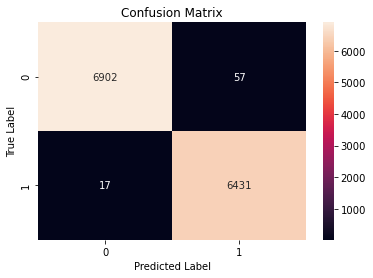

In [60]:
# Instantiating a Gradient Boosting Classifier
grad_boost = GradientBoostingClassifier()

# Fiiting to train set
grad_boost.fit(tfidf_train, y_train)

# Scoring the gradient boosting classifier
score_model(grad_boost, y_test, tfidf_test)

The Gradient Boosting model performs slightly better than the Ada Boosting model with an accuracy score of 99.4%. This implies that a news article is correctly classified 99.4% of the time.

The precision and recall scores are 99.1 % and 99.7 %. This implies that out of the total real news, 99.4 % were truly real.

17 samples were classified as fake yet they were true. On the other hand, 57 samples were classified as true yet they were false.

13333 samples were correctly classified correctly.

#### 4.3.3 XG Boosting Classifier

Precision: 0.996 / Recall: 0.998 / F1-Score: 0.997 / Accuracy: 0.997


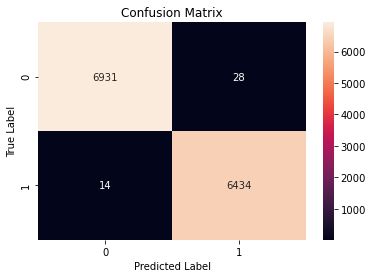

In [61]:
# Instantiating a class of XG Boost
xg_boost = XGBClassifier()

# Fitting on training data
xg_boost.fit(tfidf_train, y_train)

# scoring the XG Boost Classifier
score_model(xg_boost, y_test, tfidf_test)

The XG Boost model performs better than the other models with an accuracy score of 99.7 %. This implies that a news article is correctly classified 99.7 % of the time.

The precision and recall scores are 99.8 % and 99.6 % respectively. This implies that out of the total real news, 99.8 % are truly real.

14 samples were classified as fake yet they were true. On the other hand, 28 samples were classified as true yet they were false.

13365 samples were correctly classified correctly.

### 4.4 ROC Curves

In [62]:
# Creating a class that generates tpr and fpr for Area under the curve from ROC
class get_roc(object):
    """ A function that gets the roc values"""

    def train_rates(model, feature_train, target_train):
        """ A fucntion that gets the true positive rate, false positive rate and the thresholds"""
        
        # Calculate the fpr, tpr, and thresholds for the training set
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        # ROC curve for training set
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(model_train_fpr, model_train_tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
        plt.legend(loc='lower right')
        print('Training AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))
        plt.show()
        
    def test_rates (model, feature_test, target_test):
        """ A fucntion that gets the true positive rate, false positive rate and the thresholds"""
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        # ROC curve for training set
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(model_test_fpr, model_test_tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
        plt.legend(loc='lower right')
        print('Testing AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        plt.show()
        
    def combined_rates(model, feature_train, feature_test, target_train, target_test):
        """ A function that gets the roc curves of both train and test in one plot"""
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Calculate the probability scores of each point in the test set
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        print('Model Test AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        print('Model Train AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))
        
        plt.figure(figsize=(10,8))
        lw = 2
        
        plt.plot(model_test_fpr, model_test_tpr, color='darkorange',
         lw=lw, label='Model Test ROC curve')
        plt.plot(model_train_fpr, model_train_tpr, color='blue',
         lw=lw, label='Model Train ROC curve')
        
        # Formatting
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    def get_auc(model, feature_train, feature_test, target_train, target_test):
        """ A function that gets the roc curves of both train and test in one plot"""
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Calculate the probability scores of each point in the test set
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        print('Model Test AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        print('Model Train AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))

#### 4.4.1 Logistic Regression ROC

Model Test AUC: 0.9981544018724348
Model Train AUC: 0.9991561385060419


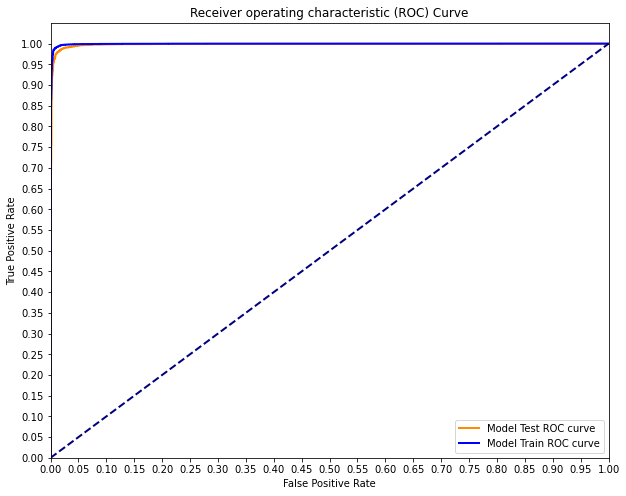

In [63]:
lr_combined = get_roc.combined_rates(lr, tfidf_train, tfidf_test, y_train, y_test)

#### 4.4.2 Random Forest ROC

The area under the curve of the random forest is 0.9981389801021724


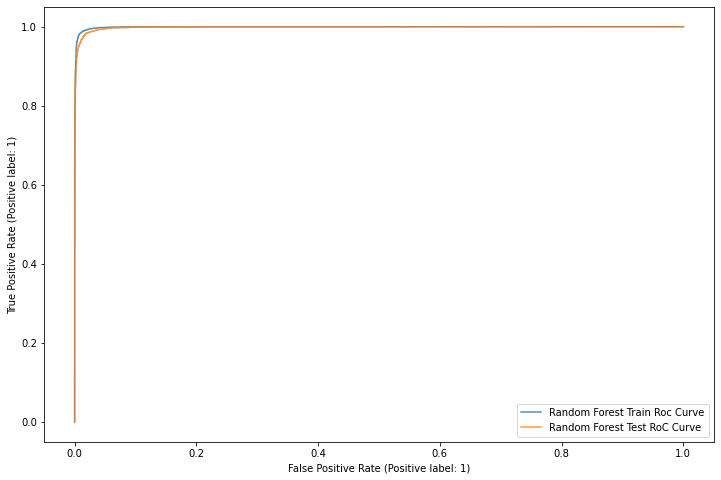

In [64]:
print(f"The area under the curve of the random forest is {roc_auc_score(y_test, rf.predict_proba(tfidf_test)[:,1])}")
# Plotting ROC curve for Random Forest
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
rf_train = RocCurveDisplay.from_estimator(rf, tfidf_train, y_train, ax=ax, alpha=0.8, label ='Random Forest Train Roc Curve')
rf_disp = RocCurveDisplay.from_estimator(rf, tfidf_test, y_test, ax=ax, alpha=0.8, label= 'Random Forest Test RoC Curve')
plt.show()

#### 4.4.3 Ada Boosting Classifier ROC

In [65]:
print(f"The area under the curve of the Ada Boosting classifier is {roc_auc_score(y_test, ada_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the Ada Boosting classifier is 0.9993908623604331


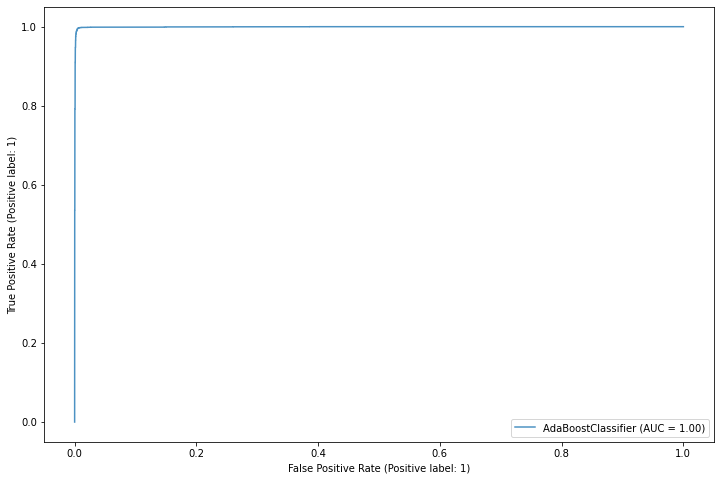

In [66]:
# Plotting ROC curve for Ada Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
ada_disp = RocCurveDisplay.from_estimator(ada_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

#### 4.4.4 Gradient Boosting Classifier ROC

In [67]:
print(f"The area under the curve of the gradient boosting classifier is {roc_auc_score(y_test, grad_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the gradient boosting classifier is 0.9987050170138675


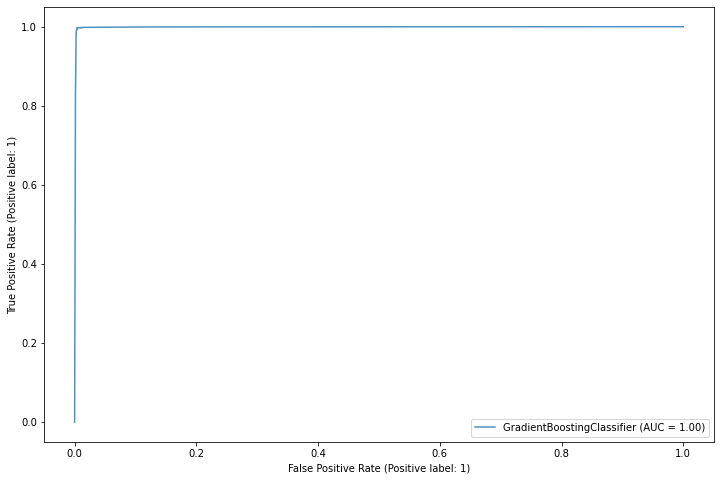

In [68]:
# Plotting ROC curve for Gradient Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
grad_disp = RocCurveDisplay.from_estimator(grad_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

#### 4.4.5 XG Boosting Classifier ROC

In [69]:
print(f"The area under the curve of the XG Boost is {roc_auc_score(y_test, xg_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the XG Boost is 0.9997360693277214


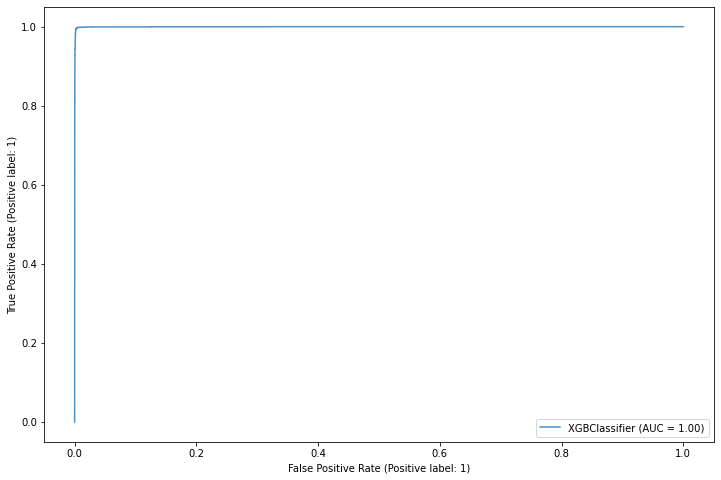

In [70]:
# Plotting ROC curve for XG Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
xg_disp = RocCurveDisplay.from_estimator(xg_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

### 4.5 Summary Table

In [71]:
# A class that gets scores
class get_scores(object):
    """ a class that gets the scores from a model"""
    def acc(model, x, y):
        """ A function that gets the accuracy score"""
        y_pred = model.predict(x)
        score = accuracy_score(y, y_pred)
        return score
    
    def precision (model, x, y):
        """ A function that gets the precision scores"""
        return precision_score(y, model.predict(x))
    
    def recall(model, x, y):
        """ A function that gets the recall scores"""
        return recall_score(y, model.predict(x))
    
    def f1 (model, x, y):
        """ A function that that gets the f1 scores"""
        return f1_score(y, model.predict(x))
    

In [72]:
# Creating instances of get_scores class
lr_scores  = get_scores
rf_scores = get_scores
gb_score = get_scores
ada_score = get_scores
xg_score = get_scores


####  4.5.1 Train Summary Table

In [73]:
# train summary table
train_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              })

In [74]:
# train summary
train_summary_table.loc[0] = ["Logistic Regression",
                         lr_scores.acc(lr, tfidf_train, y_train),
                         lr_scores.precision(lr, tfidf_train, y_train),
                         lr_scores.recall(lr, tfidf_train, y_train),
                         lr_scores.f1(lr, tfidf_train, y_train)]

train_summary_table.loc[2] = ["Random Forest",
                        rf_scores.acc(rf, tfidf_train, y_train),
                        rf_scores.precision(rf, tfidf_train, y_train),
                        rf_scores.recall(rf, tfidf_train, y_train),
                        rf_scores.f1(rf, tfidf_train, y_train)]

train_summary_table.loc[2] = ["Gradient Boost",
                        gb_score.acc(grad_boost, tfidf_train, y_train),
                        gb_score.precision(grad_boost, tfidf_train, y_train),
                        gb_score.recall(grad_boost, tfidf_train, y_train),
                        gb_score.f1(grad_boost, tfidf_train, y_train)]

train_summary_table.loc[3] = ["Ada Boosting Classifier",
                        ada_score.acc(ada_boost, tfidf_train, y_train),
                        ada_score.precision(ada_boost, tfidf_train, y_train),
                        ada_score.recall(ada_boost, tfidf_train, y_train),
                        ada_score.f1(ada_boost, tfidf_train, y_train)]

train_summary_table.loc[4] = ["XG Boosting Classifier",
                        xg_score.acc(xg_boost, tfidf_train, y_train),
                        xg_score.precision(xg_boost, tfidf_train, y_train),
                        xg_score.recall(xg_boost, tfidf_train, y_train),
                        xg_score.f1(xg_boost, tfidf_train, y_train)]

In [81]:
# showing the train summary table
train_summary_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.990154,0.987718,0.991465,0.989588
2,Gradient Boost,0.997347,0.995879,0.998510,0.997193
3,Ada Boosting Classifier,0.996867,0.995942,0.997426,0.996683
4,XG Boosting Classifier,0.999968,1.000000,0.999932,0.999966


####  4.5.2 Test Summary Table

In [75]:
# test summary table
#summary table
test_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              })

test_summary_table.loc[0] = ["Logistic Regression",
                         lr_scores.acc(lr, tfidf_test, y_test),
                         lr_scores.precision(lr, tfidf_test, y_test),
                         lr_scores.recall(lr, tfidf_test, y_test),
                         lr_scores.f1(lr, tfidf_test, y_test)]

test_summary_table.loc[1] = ["Random Forest",
                         rf_scores.acc(rf, tfidf_test, y_test),
                         rf_scores.precision(rf, tfidf_test, y_test),
                         rf_scores.recall(rf, tfidf_test, y_test),
                         rf_scores.f1(rf, tfidf_test, y_test)]

test_summary_table.loc[2] = ["Gradient Boost",
                        gb_score.acc(grad_boost, tfidf_test, y_test),
                        gb_score.precision(grad_boost, tfidf_test, y_test),
                        gb_score.recall(grad_boost, tfidf_test, y_test),
                        gb_score.f1(grad_boost, tfidf_test, y_test)]

test_summary_table.loc[3] = ["Ada Boosting Classifier",
                        ada_score.acc(ada_boost, tfidf_test, y_test),
                        ada_score.precision(ada_boost, tfidf_test, y_test),
                        ada_score.recall(ada_boost, tfidf_test, y_test),
                        ada_score.f1(ada_boost, tfidf_test, y_test)]

test_summary_table.loc[4] = ["XG Boosting Classifier",
                        xg_score.acc(xg_boost, tfidf_test, y_test),
                        xg_score.precision(xg_boost, tfidf_test, y_test),
                        xg_score.recall(xg_boost, tfidf_test, y_test),
                        xg_score.f1(xg_boost, tfidf_test, y_test)]

# showing the test summary table
test_summary_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.983143,0.982326,0.982630,0.982478
1,Random Forest,0.981726,0.980183,0.981855,0.981018
2,Gradient Boost,0.994480,0.991215,0.997364,0.994280
3,Ada Boosting Classifier,0.995376,0.993967,0.996433,0.995198
4,XG Boosting Classifier,0.996867,0.995667,0.997829,0.996747


### 4.6 Cross Validation

In [76]:
# Creating a class that performs a cross validation score
class cross_v_scores(object):
    """ A class that performs cross validation"""
    def acc_score(model, x, y):
        """ A function that gets the mean cross validation accuracy"""
        mean_score = np.mean(cross_val_score(model, x, y, cv=3, scoring='accuracy'))
        return mean_score
    
    def mse(model, x, y):
        """ A function that calculates the mean squared error"""
        mean_mse = np.mean(-cross_val_score(model, x, y, cv=5, scoring="neg_mean_squared_error"))
        return mean_mse

In [77]:
lr_cv = cross_v_scores
rf_cv = cross_v_scores
ada_cv = cross_v_scores
grad_cv = cross_v_scores
xg_cv = cross_v_scores

In [78]:
# Creating a cross validation summary table
cross_validation_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'mean squared error': [],
                              })

In [79]:
# logistic regression
cross_validation_summary_table.loc[0] = ["Logistic Regression",
                                         lr_cv.acc_score(lr, tfidf_test, y_test),
                                         lr_cv.mse(lr, tfidf_test, y_test)]

# random forest
cross_validation_summary_table.loc[1] = ["Random Forest",
                                         rf_cv.acc_score(rf, tfidf_test, y_test),
                                         rf_cv.mse(rf, tfidf_test, y_test)]


# XG Boost
cross_validation_summary_table.loc[4] = ["XG Boosting Classifier",
                                         xg_cv.acc_score(xg_boost, tfidf_test, y_test),
                                         xg_cv.mse(xg_boost, tfidf_test, y_test)]

# showing the table
cross_validation_summary_table


,Model,Accuracy,mean squared error
0,Logistic Regression,0.971955,0.025509
1,Random Forest,0.966808,0.033639
4,XG Boosting Classifier,0.994779,0.004848


### 5. Evaluation

### 6. Deployment

In [82]:
# Create a pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('xgb', XGBClassifier())])

pipe.fit(X_train, y_train)

pipe.predict(X_test)

# Pickle the pipeline
pickle.dump(pipe, open('./models/model.pkl', 'wb'))

array([1, 0, 0, ..., 0, 0, 1])